# **Xtinguish** Preventing Wild Fires using CNNs

**Xtinguish** is an CNN Image Classfication model which helps in detecting and preventing **Wildfires**.



#### **Checking the GPU**

For this Project we will working with **Mixed Precision**. And mixed precision works best with a with a GPU with compatibility capacity **7.0+**.

At the time of writing, colab offers the following GPU's :
* Nvidia K80
* **Nvidia T4**
* Nvidia P100

Colab allocates a random GPU everytime we factory reset runtime. So you can reset the runtime till you get a **Tesla T4 GPU** as T4 GPU has a rating 7.5.

> In case using local hardware, use a GPU with rating 7.0+ for better results.

Run the below cell to see which GPU is allocated to you.

In [ ]:
!nvidia-smi -L

### **Mounting GDrive**

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Importing required Packages**

In [41]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
!wget https://raw.githubusercontent.com/gauravreddy08/deep-learning-tensorflow/main/extras/helper_function.py

--2021-06-25 18:08:07--  https://raw.githubusercontent.com/gauravreddy08/deep-learning-tensorflow/main/extras/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_function.py.4’

helper_function.py. 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-25 18:08:07 (65.2 MB/s) - ‘helper_function.py.4’ saved [10246/10246]



In [43]:
from helper_function import create_tensorboard_callback

#### **Downloading Tensorflow 2.4.1**

At the time of writing, `tesnorflow 2.5.0` has a bug with EfficientNetBX Models. [Click Here](https://github.com/tensorflow/tensorflow/issues/49725) to get more info about the bug.

In [44]:
# !pip install tensorflow==2.4.1

### **Getting the Data ready**

In [61]:
DATA_PATH = "/content/drive/MyDrive/WildFire Detection/data/"

train_data = tf.keras.preprocessing.image_dataset_from_directory(DATA_PATH,
                                                                 label_mode='binary',
                                                                 validation_split=0.2,
                                                                 image_size=(224, 224),
                                                                 batch_size=32,
                                                                 seed=42,
                                                                 subset='training')

test_data = tf.keras.preprocessing.image_dataset_from_directory(DATA_PATH,
                                                                label_mode='binary',
                                                                validation_split=0.2,                                                             
                                                                image_size=(224, 224),
                                                                batch_size=32,
                                                                seed=42,
                                                                subset='validation')

Found 4059 files belonging to 2 classes.
Using 3248 files for training.
Found 4059 files belonging to 2 classes.
Using 811 files for validation.


### **Setting up the Callbacks**

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystopping = EarlyStopping(monitor='val_acc',
                              patience=2,
                              restore_best_weights=True)

lower_lr = ReduceLROnPlateau(monitor='val_acc',
                             factor=0.2,
                             patience=0,
                             min_lr=1e-7)

In [47]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fa2bcb79-7a8b-14b7-3ee5-268498adf21f)


In [48]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

### **Building the Model**

In [49]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Activation

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True

inputs = Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)

x = GlobalAveragePooling2D(name="activation_layer")(x)
x = Dropout(0.3)(x)

x = Dense(1, name='output_layer')(x)
outputs = Activation('sigmoid', name='sigmoid_activation_layer')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics = ['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
activation_layer (GlobalAver (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1281      
_________________________________________________________________
sigmoid_activation_layer (Ac (None, 1)                 0         
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
____________________________________________

In [50]:
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(len(test_data)*0.25))

Epoch 1/10
102/102 [==============================] - 34s 225ms/step - loss: 0.1989 - accuracy: 0.9086 - val_loss: 0.3319 - val_accuracy: 0.8958
Epoch 2/10
102/102 [==============================] - 22s 207ms/step - loss: 0.0728 - accuracy: 0.9765 - val_loss: 0.1931 - val_accuracy: 0.9427
Epoch 3/10
102/102 [==============================] - 21s 203ms/step - loss: 0.0208 - accuracy: 0.9928 - val_loss: 0.1469 - val_accuracy: 0.9635
Epoch 4/10
102/102 [==============================] - 21s 204ms/step - loss: 0.0379 - accuracy: 0.9878 - val_loss: 0.2304 - val_accuracy: 0.9583
Epoch 5/10
102/102 [==============================] - 21s 204ms/step - loss: 0.0329 - accuracy: 0.9882 - val_loss: 0.1015 - val_accuracy: 0.9688
Epoch 6/10
102/102 [==============================] - 21s 204ms/step - loss: 0.0246 - accuracy: 0.9919 - val_loss: 0.0924 - val_accuracy: 0.9740
Epoch 7/10
102/102 [==============================] - 21s 204ms/step - loss: 0.0193 - accuracy: 0.9911 - val_loss: 0.0973 - val_ac

### **Evaluating our Model**

In [51]:
model.evaluate(test_data)

26/26 [==============================] - 3s 84ms/step - loss: 0.2456 - accuracy: 0.9494


[0.2455950826406479, 0.9494451284408569]

In [52]:
class_names=['Fire', 'No Fire']

In [62]:
test_data = test_data.unbatch()

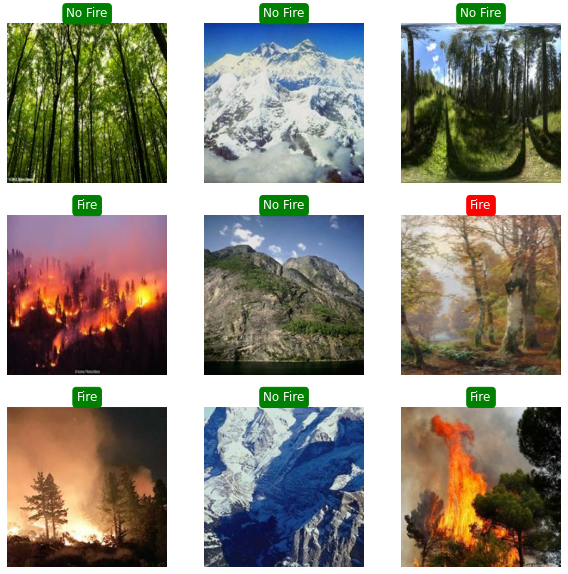

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(9):
  for images, labels in test_data.take(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    x=labels.numpy()

    pred_prod = model.predict(tf.expand_dims(images, axis=0))
    pred = class_names[np.round(int(pred_prod[0]))]
    
    if pred==class_names[int(x)]: plt.title(f"{pred}", color='white', bbox=dict(boxstyle="round", color='green'))
    else: plt.title(f"{pred}", color='white', bbox=dict(boxstyle="round", color='red'))

    plt.axis("off")

### **Exporting the model**

In [102]:
model.save("/content/drive/MyDrive/WildFire Detection/SavedModels/baseline_model.hdf5")